# CNN

In [3]:
import os
from multiprocessing import freeze_support

import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import wandb

In [4]:
# Device agnostic code
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")

    if torch.backends.mps.is_available():
        return torch.device("mos")
    return torch.device("cpu")

In [94]:
get_default_device()

device(type='cuda')

In [96]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
class CachedDataset(Dataset):
    def __init__(self, dataset, cache=True):
        if cache:
            dataset = tuple([x for x in dataset])
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.dataset[i]

In [102]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
val_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

In [103]:
# transforms = [
#         v2.ToImage(),
#         v2.ToDtype(torch.float32, scale=True),
#         v2.Resize((64, 64), antialias=True),
#         # v2.Grayscale()
#         # torch.flatten,
#     ]

In [104]:
data_path = "../data"

train_dataset = CIFAR10(
    root=data_path, train=True, transform=train_transforms, download=True
)
val_dataset = CIFAR10(
    root=data_path, train=False, transform=val_transforms, download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [105]:
print(f"Train data:\n{train_dataset}\nTest data:\n{val_dataset}")

Train data:
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [106]:
# Cached dataset (optional)
# train_dataset = CachedDataset(train_dataset)
# val_dataset = CachedDataset(val_dataset)
# print(f"Train data:\n{train_dataset}\nTest data:\n{val_dataset}")

In [107]:
# Get class names as a list
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [108]:
# Can also get class names as a dict
class_dict = train_dataset.class_to_idx
class_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [109]:
# Check the lengths
len(train_dataset), len(val_dataset)

(50000, 10000)

In [110]:
img, label = train_dataset[0][0], val_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.2039, 0.1843, 0.1490,  ..., 0.6118, 0.6039, 0.5961],
         [0.1529, 0.1373, 0.1020,  ..., 0.5765, 0.5725, 0.5725],
         [0.0588, 0.0431, 0.0078,  ..., 0.5098, 0.5098, 0.5137],
         ...,
         [0.7333, 0.7255, 0.7137,  ..., 0.4157, 0.3765, 0.3529],
         [0.7294, 0.7216, 0.6980,  ..., 0.5255, 0.4706, 0.4431],
         [0.7255, 0.7176, 0.6941,  ..., 0.5804, 0.5176, 0.4863]],

        [[0.2157, 0.2000, 0.1608,  ..., 0.4941, 0.4902, 0.4902],
         [0.1725, 0.1490, 0.1137,  ..., 0.4510, 0.4510, 0.4510],
         [0.0784, 0.0549, 0.0118,  ..., 0.3569, 0.3686, 0.3686],
         ...,
         [0.5608, 0.5451, 0.5137,  ..., 0.2627, 0.2353, 0.2196],
         [0.5765, 0.5569, 0.5255,  ..., 0.3804, 0.3294, 0.3059],
         [0.5804, 0.5608, 0.5294,  ..., 0.4392, 0.3804, 0.3490]],

        [[0.2196, 0.2039, 0.1608,  ..., 0.3922, 0.3961, 0.3961],
         [0.1725, 0.1529, 0.1137,  ..., 0.3412, 0.3451, 0.3490],
         [0.0784, 0.0549, 0.0118,  ..., 0.22

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


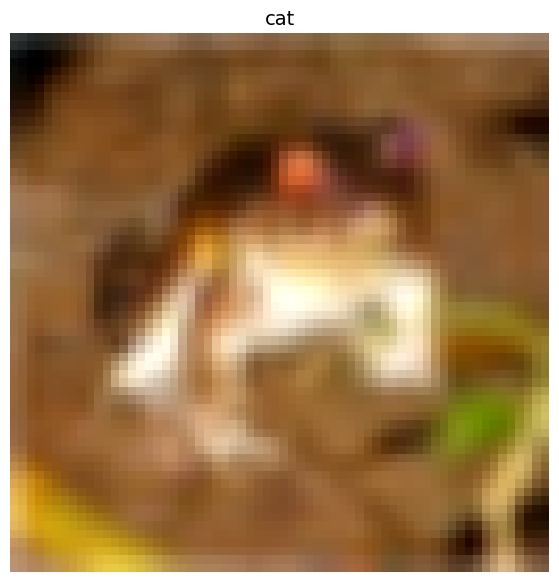

In [111]:
import matplotlib.pyplot as plt
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [112]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 64
NUM_WORKERS = 0
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=val_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

Creating DataLoader's with batch size 64 and 0 workers.


(<torch.utils.data.dataloader.DataLoader at 0x2743e961f10>,
 <torch.utils.data.dataloader.DataLoader at 0x2743e887450>)

In [113]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


#### Create a function to display random images

In [114]:
import random
import os
import numpy as np
from typing import Tuple, Dict, List
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

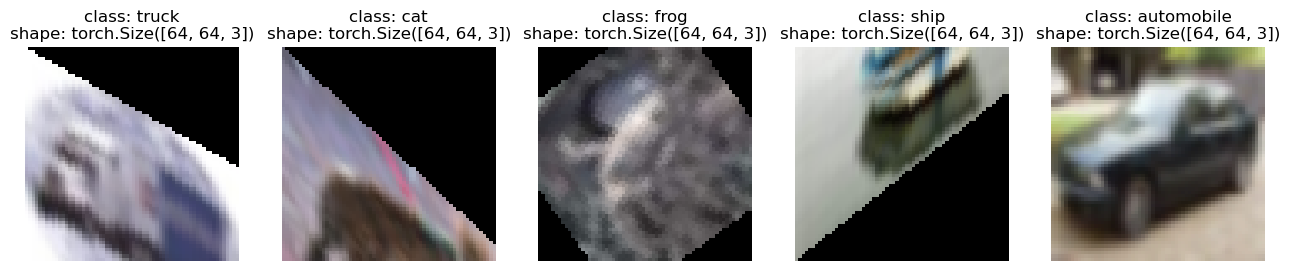

In [115]:
# Display random images from CIFAR10 created Dataset
display_random_images(train_dataset, 
                      n=5, 
                      classes=class_names,
                      seed=None)

### Model 0: TinyVGG with data augmentation

In [120]:
import torch.nn as nn
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_dataset.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=10, bias=True)
  )
)

### A single forward pass

In [121]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0095,  0.0096,  0.0505, -0.0056,  0.0202,  0.0010,  0.0167,  0.0723,
          0.0352, -0.0727]], device='cuda:0')

Output prediction probabilities:
tensor([[0.0995, 0.0995, 0.1037, 0.0980, 0.1006, 0.0987, 0.1002, 0.1060, 0.1021,
         0.0917]], device='cuda:0')

Output prediction label:
tensor([7], device='cuda:0')

Actual label:
6


In [122]:
import torchinfo
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [123]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [124]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [125]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\Iosif\anaconda3\envs\atnn2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [126]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_dataset.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:34<02:17, 34.29s/it]

Epoch: 1 | train_loss: 2.0477 | train_acc: 0.2531 | test_loss: 1.7465 | test_acc: 0.3792


 40%|████      | 2/5 [01:08<01:42, 34.18s/it]

Epoch: 2 | train_loss: 1.9258 | train_acc: 0.3102 | test_loss: 1.6946 | test_acc: 0.4029


 60%|██████    | 3/5 [01:42<01:08, 34.14s/it]

Epoch: 3 | train_loss: 1.8687 | train_acc: 0.3306 | test_loss: 1.6576 | test_acc: 0.4028


 80%|████████  | 4/5 [02:16<00:34, 34.12s/it]

Epoch: 4 | train_loss: 1.7961 | train_acc: 0.3570 | test_loss: 1.5449 | test_acc: 0.4452


100%|██████████| 5/5 [02:50<00:00, 34.09s/it]

Epoch: 5 | train_loss: 1.7428 | train_acc: 0.3743 | test_loss: 1.4723 | test_acc: 0.4736
Total training time: 170.468 seconds


In [128]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,2.047728,0.253077,1.746461,0.379180
1,1.925826,0.310202,1.694564,0.402866
2,1.868724,0.330623,1.657643,0.402767
3,1.796098,0.357017,1.544887,0.445163
4,1.742836,0.374321,1.472313,0.473627
